In [ ]:
pip install transformers

In [ ]:
#Libraries
import pandas as pd
import numpy as np
import scipy
import  os
import random
import time
import datetime
import nltk

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score

from keras.preprocessing.sequence import pad_sequences

from tqdm import trange
import random

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, BertConfig
from transformers import get_linear_schedule_with_warmup
from transformers import BertTokenizer,AutoTokenizer, AutoModel
from torch.optim import AdamW


In [ ]:
df = pd.read_excel(r'/content/sample_data/augmentedDataset2.xlsx')

In [ ]:
pos_comments = df[df['Label'] == 'POS']['Comment'].tolist()
ntr_comments = df[df['Label'] == 'NTR']['Comment'].tolist()
neg_comments = df[df['Label'] == 'NEG']['Comment'].tolist()

In [ ]:
pos_comments = pos_comments[:1679]
ntr_comments = ntr_comments[:1679]

In [ ]:
Comments = pos_comments + ntr_comments + neg_comments
Labels = ['POS'] * len(pos_comments) + ['NTR'] * len(ntr_comments) + ['NEG'] * len(neg_comments)

In [ ]:
Data = pd.DataFrame({
    'Comments': Comments,
    'polarity': Labels,
})

In [ ]:
Data.head()

,Comments,polarity
0,الله يعطيك الصحة,POS
1,حلقتك روعة,POS
2,شكرا على الفيديو بصحتك الله يعطيك الصحة مطعم ي...,POS
3,ماشاء الله عليك اللهم بارك تحياتي لك اخي بالتو...,POS
4,اكيد كتجربة الماكلة حتى كنعياو مكينش بحال الدا...,POS


In [ ]:
mapping = {
    'POS': 0,
    'NTR': 1,
    'NEG': 2
}

In [ ]:
Data['labels'] = Data['polarity'].map(mapping)

In [ ]:
Data.head()

,Comments,polarity,labels
0,الله يعطيك الصحة,POS,0
1,حلقتك روعة,POS,0
2,شكرا على الفيديو بصحتك الله يعطيك الصحة مطعم ي...,POS,0
3,ماشاء الله عليك اللهم بارك تحياتي لك اخي بالتو...,POS,0
4,اكيد كتجربة الماكلة حتى كنعياو مكينش بحال الدا...,POS,0


In [ ]:
Data.labels.value_counts()
Comments = Data.Comments.values
labels = Data.labels.values

In [ ]:
#GPU device
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:
print(device)

cuda


In [ ]:
import torch.nn as nn

loss_fn = nn.CrossEntropyLoss()

def evaluate(model, val_dataloader):

           # Put the model into the evaluation mode. The dropout layers are disabled during
            model.eval()
            # Tracking variables
            val_accuracy = []
            val_loss = []
            # For each batch in our validation set...
            for batch in val_loader:
                # Load batch to GPU
                b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
                # Compute logits
                with torch.no_grad():
                  logits = model(b_input_ids, b_input_mask)
                  # Compute loss
                  loss = loss_fn(logits.logits, b_labels)
                val_loss.append(loss.item())
                # Get the predictions
                preds = torch.argmax(logits.logits, dim=1).flatten()
                # Calculate the accuracy rate
                accuracy = (preds == b_labels).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)
            # Compute the average accuracy and loss over the validation set.
            val_loss = np.mean(val_loss)
            val_accuracy = np.mean(val_accuracy)
            return val_loss, val_accuracy

In [ ]:
#Evaluation du modèle --> calculer les probabilités par "softmax"
import torch.nn.functional as F

def dev_predict(model, test_dataloader) :

  # mettre le modèle en mode d'évaluation
  model.eval()
  all_logits = []

  for batch in test_dataloader:
    # Load batch to GPU
    b_input_ids, b_input_mask = tuple(t.to(device) for t in batch)[:2]

    # Compute logits
    with torch.no_grad():
      logits = model(b_input_ids, b_input_mask)
    all_logits.append(logits.logits)
    # Concatenate logits from each batch
  all_logits = torch.cat(all_logits, dim=0)
  # Apply softmax to calculate probabilities
  probs = F.softmax(all_logits, dim=1).cpu().numpy()
  return probs

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_acc(val_acc_per_epoch,val_loss_per_epoch):


  mean_val_acc = np.mean(val_acc_per_epoch, axis=0)
  mean_val_loss = np.mean(val_loss_per_epoch, axis=0)

  # Plotting mean validation accuracy across epochs
  plt.plot(mean_val_acc, label='Mean Validation Accuracy')
  plt.title('Mean Validation Accuracy across Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  # Plotting mean validation loss across epochs
  plt.plot(mean_val_loss, label='Mean Validation Loss')
  plt.title('Mean Validation Loss across Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [ ]:
def train_final(data,LR=2e-5,nepochs=5,Batches=16):

    # nombre d'époques
    epochs = nepochs

    #seed(int) Fonction d'assistance pour un comportement reproductible pour définir la valeur seed dans random,numpy,torch

    seed_val = 42
    batch_size = Batches
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    #torch.cuda.manual_seed_all(seed_val)

    val_acc_per_epoch=[]
    val_loss_per_epoch=[]





    # Tell pytorch to run this model on the GPU.
    model.cuda()
    #model.cpu()



    # Total number of training steps is number of batches * number of epochs.
    total_steps = len(train_loader) * epochs

    # Create the learning rate scheduler. --> sheduler: qui controle le taux d'apprentissage
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

    # Store the average loss after each epoch so we can plot them.
    loss_values = []
    print("")
    print("Start training...\n")
    # pour chaque époque
    for epoch_i in range(0,epochs):

        #training
        # Perform one full pass over the training set.


        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        # `train` just changes the *mode*, it doesn't *perform* the training.
        # `dropout` and `batchnorm` layers behave differently during training
        model.train()


        # For each batch of training data...
        for step, batch in enumerate(train_loader):
            batch_counts+=1

            # Unpack this training batch from our dataloader.
            # As we unpack the batch, we'll also copy each tensor to the GPU using the
            # `to` method.
            # `batch` contains three pytorch tensors:
            #   [0]: input ids
            #   [1]: attention masks
            #   [2]: labels
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because
            # accumulating the gradients is "convenient while training RNNs".
            model.zero_grad()

            # Perform a forward pass (evaluate the model on this training batch).
            # This will return the loss (rather than the model output) because we
            # have provided the `labels`.
            outputs = model(b_input_ids,
                              token_type_ids=None,
                              attention_mask=b_input_mask,
                              labels=b_labels.to(device=device, dtype=torch.int64)
                           )

            # The call to `model` always returns a tuple, so we need to pull the
            # loss value out of the tuple.
            loss = outputs[0]

            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value
            # from the tensor.
            total_loss += loss.item()
            batch_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

              # Progress update every 16 batches.
            if step % 10 == 0 and not step == 0:

                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0_batch)
                # Report progress.

                # Print training results
                print(f"{(epoch_i+1):^7} | {step:^7} | {batch_loss / batch_counts:^12.6} | {'-':^10} | {'-':^9} | {format(time.time()-t0_batch):^9.2}")
                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()
                # Calculate the average loss over the entire training data
                avg_train_loss = total_loss / len(train_loader)
                print("-"*70)

        # Calculate the average loss over the training data.
        avg_train_loss = total_loss / len(train_loader)

        # Store the loss value for plotting the learning curve.
        loss_values.append(avg_train_loss)


        #evaluation
        time_elapsed = format_time(time.time() - t0_batch)
        # mesurer la performance du modèle
        val_loss, val_accuracy = evaluate(model, val_loader)
        val_acc_per_epoch.append(val_accuracy)
        val_loss_per_epoch.append(val_loss)
        print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6} | {val_loss:^10.6} | {val_accuracy:^9.2} | {format(time.time()-t0_batch):^9.2}")
        print("-"*70)
        print("\n")
    val_loss_per_fold.append(val_loss_per_epoch)
    val_acc_per_fold.append(val_acc_per_epoch)
    print(val_acc_per_fold)
    print(val_loss_per_fold)




In [ ]:

#function to calculate f1 score
def flat_f1(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat,pred_flat)

#function Takes a time in seconds and returns a string hh:mm:ss
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
val_acc_per_fold=[]
val_loss_per_fold=[]
# Initialisation du tokenizer
tokenizer = AutoTokenizer.from_pretrained("Kamel/DarijaBERT")


# Nombre de folds pour la validation croisée
kfold = StratifiedKFold(n_splits=3, shuffle=True)

for fold, (train_idx, val_idx) in enumerate(kfold.split(Comments, labels)):
    print(f"Fold {fold + 1}/{kfold.get_n_splits()}")

    # Séparation des données en ensembles d'entraînement et de validation pour ce fold
    train_comments = [Comments[i] for i in train_idx]
    val_comments = [Comments[i] for i in val_idx]
    train_labels = [labels[i] for i in train_idx]
    val_labels = [labels[i] for i in val_idx]

    # Tokenisation des textes
    train_encodings = tokenizer(train_comments, truncation=True, padding=True)
    val_encodings = tokenizer(val_comments, truncation=True, padding=True)

    # Création des tenseurs pour les entrées du modèle
    train_dataset = torch.utils.data.TensorDataset(
        torch.tensor(train_encodings['input_ids']),
        torch.tensor(train_encodings['attention_mask']),
        torch.tensor(train_labels)
    )
    val_dataset = torch.utils.data.TensorDataset(
        torch.tensor(val_encodings['input_ids']),
        torch.tensor(val_encodings['attention_mask']),
        torch.tensor(val_labels)
    )
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    #Training loop
     # Téléchargez transformers.BertForSequenceClassification
    # qui est un modèle BERT avec une couche linéaire pour la classification des phrases
    bert_repo="Kamel/DarijaBERT"
    model = BertForSequenceClassification.from_pretrained(
            bert_repo, # Use the 12-layer BERT model, with an uncased vocab.
            num_labels = 3, # The number of output labels.
            output_attentions = False, # Whether the model returns attentions weights.
            output_hidden_states = True, # Whether the model returns all hidden-states.
            )

      # Mise en place d'un optimisateur
    # AdamW est un algorithme d'optimisation qui peut etre utilisé à la place de la procédure classique
    # de descente de gradient stochastique
    #pour mettre à jour les poids du réseaux de manière itérative en fct des données d'apprentissage.
    optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

    # Entraînement du modèle
    model_final=train_final(train_dataset,Batches=32,nepochs=3)
print("")
print("Training complete!")

# À la fin de chaque fold, évaluez et enregistrez les performances du modèle sur les données de validation.
plot_acc(val_acc_per_fold,val_loss_per_fold)
probabilities = dev_predict(model, val_loader)


In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

def evaluate_roc(probabilities, val_labels):
    probabilities_np = np.array(probabilities)  # Convertir la liste de listes en un tableau numpy
    val_labels_np = np.array(val_labels)  # Convertir les étiquettes en un tableau numpy

    # Calculer la courbe ROC pour chaque classe
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(3):
        # Préparer les étiquettes binarisées pour cette classe
        y_true_class = np.zeros_like(val_labels_np)
        y_true_class[val_labels_np == i] = 1

        # Extraire les probabilités softmax pour cette classe
        y_pred_class = probabilities_np[:, i]

        # Calculer la courbe ROC
        fpr[i], tpr[i], _ = roc_curve(y_true_class, y_pred_class)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure(figsize=(8, 6))

    for i in range(3):
        plt.plot(fpr[i], tpr[i], label='ROC curve (class %d) AUC = %0.2f' % (i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for each class')
    plt.legend(loc='best')
    plt.show()

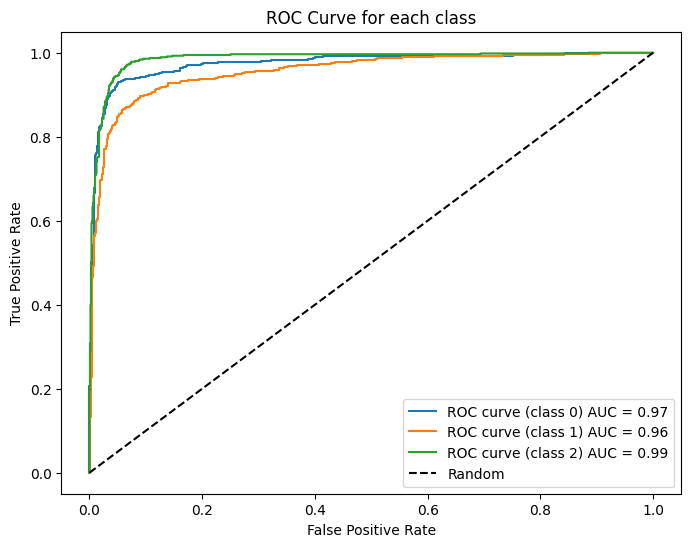

In [ ]:
evaluate_roc(probabilities, val_labels)

In [ ]:
predicted_classes = [np.argmax(probs) for probs in probabilities]
accuracy = accuracy_score(val_labels, predicted_classes)
print(f'Accuracy: {accuracy*100:.2f}%')


Accuracy: 90.11%


In [ ]:
# Calcul du F1 score pour chaque classe
f1_scores = [f1_score(val_labels, np.argmax(probabilities, axis=1), average=None)]
print("F1 Scores:", f1_scores)

F1 Scores: [array([0.91382406, 0.86456401, 0.92281304])]


# ***Test model***

In [ ]:
df = pd.read_excel(r'/content/sample_data/test_dataset.xlsx')
print(df)

                                               Comment Label
0                   تبارك الله عليك نورتينا الله ينورك   POS
1    سءال ليكايدور ليا في راسي واش كليتي ها شي كامل...   NEG
2                       كاين مراسي حتى هو رائع فمارينا   POS
3            شوفنا مطاعم في تمارة والهرهورة و   الوفاق   NTR
4                                 حلوو  الاصعار  مناسب   POS
..                                                 ...   ...
300  حيت كتر النصب و الاحتيال فالوجبات المقدمة أو ن...   NEG
301                  في فرانسا الماكلة غالية اومكتشبعش   NEG
302   الحي الذي يمكنني ان انصح به هو الحي المحمدي ف...   POS
303  لي بغا باكل عمة متنوعة ومتقونة في فضاء جميل وب...   POS
304  انا مراكشية بالمقارنة بمراكش البنة عندنا وحتى ...   POS

[305 rows x 2 columns]


In [ ]:
X_test=df['Comment']

In [ ]:
Data=df.copy()
#créer un dictionnaire qui convertit nos émotions en un chiffre pertinent
#1. liste des émotions existants
labels_existants= Data.Label.unique()

#2. énumérer les labels
labels ={}
for i,labels_existants in enumerate(labels_existants):
    labels[labels_existants] = i

#3. Ajouter une colonne au dataframe nommé label contenat les nombres uniques
Data['label'] = Data.Label.replace(labels)
Data.head()

/tmp/ipython-input-4117427721.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Data['label'] = Data.Label.replace(labels)


,Comment,Label,label
0,تبارك الله عليك نورتينا الله ينورك,POS,0
1,سءال ليكايدور ليا في راسي واش كليتي ها شي كامل...,NEG,1
2,كاين مراسي حتى هو رائع فمارينا,POS,0
3,شوفنا مطاعم في تمارة والهرهورة و الوفاق,NTR,2
4,حلوو الاصعار مناسب,POS,0


In [ ]:
Data['Label'] = Data['Label'].apply(lambda x: 1 if x == 'NTR' else 0 if x == 'POS' else 2)

In [ ]:
Data.head()

,Comment,Label,label
0,تبارك الله عليك نورتينا الله ينورك,0,0
1,سءال ليكايدور ليا في راسي واش كليتي ها شي كامل...,2,1
2,كاين مراسي حتى هو رائع فمارينا,0,0
3,شوفنا مطاعم في تمارة والهرهورة و الوفاق,1,2
4,حلوو الاصعار مناسب,0,0


In [ ]:
y_test = Data.Label.values

In [ ]:
def preprocessing_data(comments):

    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # pour chaque commentaire
    for comment in comments:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text = comment,
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=128,                  # Max length to truncate/pad
            padding= 'max_length',         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True,      # Return attention mask
            truncation=True
            )

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [ ]:
#prédire les classes sur un test_dataset
#préparer les données

#print(X_test)
test_inputs, test_masks = preprocessing_data(X_test)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

In [ ]:
test_probabilities = dev_predict(model, test_dataloader)

In [ ]:
print(test_probabilities)

[[9.97332096e-01 1.26945716e-03 1.39845943e-03]
 [8.74847407e-04 2.39623245e-02 9.75162804e-01]
 [9.96015370e-01 3.37117189e-03 6.13344950e-04]
 [1.55551899e-02 9.82057095e-01 2.38767103e-03]
 [9.96042967e-01 8.38054577e-04 3.11900047e-03]
 [9.97923732e-01 6.94214716e-04 1.38194126e-03]
 [1.93391051e-02 9.80203867e-01 4.57091868e-04]
 [2.47576497e-02 9.51254666e-01 2.39877068e-02]
 [1.09453857e-01 2.28059992e-01 6.62486196e-01]
 [1.33046438e-03 3.78497673e-04 9.98290956e-01]
 [5.74001193e-01 1.39214774e-03 4.24606711e-01]
 [9.96502995e-01 9.35797172e-04 2.56119180e-03]
 [9.95948613e-01 8.46737472e-04 3.20464349e-03]
 [1.05982402e-03 1.24836119e-03 9.97691870e-01]
 [9.90251064e-01 6.72600407e-04 9.07623116e-03]
 [7.26025901e-04 5.78387990e-04 9.98695672e-01]
 [8.06761556e-04 9.98806596e-01 3.86663363e-04]
 [9.95971620e-01 8.04549956e-04 3.22385202e-03]
 [1.34766079e-03 2.79264455e-03 9.95859683e-01]
 [1.33216276e-03 9.86768425e-01 1.18993847e-02]
 [8.67642695e-04 8.74562713e-04 9.982578

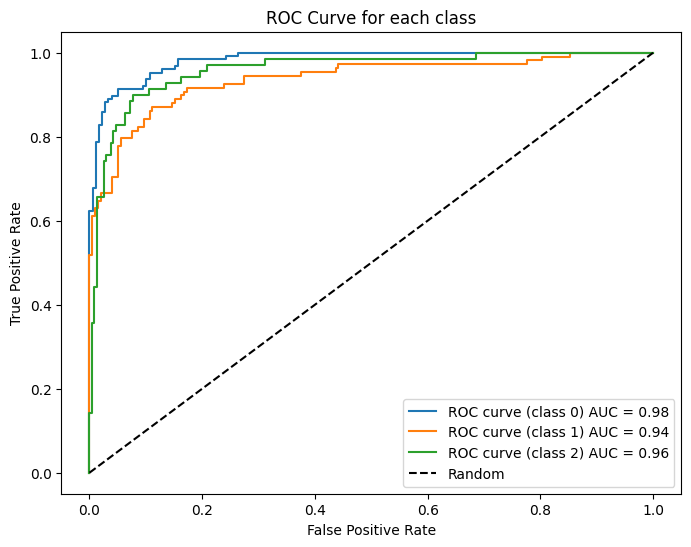

In [ ]:
evaluate_roc(test_probabilities, y_test)

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
test_predicted_classes = [np.argmax(probs) for probs in test_probabilities]
test_accuracy = accuracy_score(y_test, test_predicted_classes)
precision = precision_score(y_test, test_predicted_classes,average='macro')
recall = recall_score(y_test, test_predicted_classes,average='macro')
print(f'Accuracy: {test_accuracy*100:.2f}%')
print(f'Precision: {precision*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')

Accuracy: 86.23%
Precision: 85.11%
Recall: 86.56%


In [ ]:
# Calcul du F1 score pour chaque classe
test_f1_scores = [f1_score(y_test, np.argmax(test_probabilities, axis=1), average=None)]
print("F1 Scores:", test_f1_scores)

F1 Scores: [array([0.91803279, 0.83018868, 0.81818182])]


In [ ]:
model.save_pretrained("./finetuned_model_augdataset")
tokenizer.save_pretrained("./finetuned_model_augdataset")

('./finetuned_model_augdataset/tokenizer_config.json',
 './finetuned_model_augdataset/special_tokens_map.json',
 './finetuned_model_augdataset/vocab.txt',
 './finetuned_model_augdataset/added_tokens.json',
 './finetuned_model_augdataset/tokenizer.json')